In [1]:
import anndata as ad
import numpy as np
import torch
import pandas as pd

from geome import ann2data, iterables, transforms
import squidpy as sq

In [2]:
coordinates = np.random.rand(50, 2)
# make sure that there are two clusters of spatial coordinates
# so that the resulting splits number of edges will be the same
# as the sum of the number of edges in each cluster
func_args = {"radius": 4.0, "coord_type": "generic", "library_key": "image_id"}
coordinates[:25, 0] += 100
adata_gt = ad.AnnData(
    np.random.rand(50, 2),
    obs={"cell_type": ["b"] * 20 + ["a"] * 20 + ["c"] * 5 + ["d"] * 5, "image_id": list("xy" * 20) + ["z"] * 10},
    obsm={"spatial_init": coordinates},
)
adata_gt.obs["image_id"] = pd.Categorical(adata_gt.obs["image_id"])
sq.gr.spatial_neighbors(adata_gt, spatial_key="spatial_init", library_key="image_id")

In [34]:
import pandas as pd


def one_hot_encode(keys, axis, key_added, adata) -> None:
    """Docstring one"""
    matrix_key = f"{axis}m"  # e.g., 'obsm' or 'varm'
    encoded_data = {}
    label_mappings = {}
    encoded_data_list = []

    for key in keys:
        # Generate one-hot encoding
        categories = pd.get_dummies(getattr(adata, axis)[key])
        encoded_data[key] = categories
        encoded_data_list.append(categories)
        # Store mapping of codes to labels
        label_mappings[key] = categories.columns.tolist()

    encoded_data_combined = pd.concat(encoded_data_list, axis=1)

    # Save the encoded data and mappings in the appropriate AnnData structure
    getattr(adata, matrix_key)[key_added] = pd.DataFrame(encoded_data_combined)
    adata.uns[f"{key_added}_mappings"] = label_mappings

    return adata

In [35]:
one_hot_encode(keys=["cell_type"], axis="obs", key_added="label", adata=adata_gt)

{'cell_type': ['a', 'b', 'c', 'd']}
        a      b      c      d
0   False   True  False  False
1   False   True  False  False
2   False   True  False  False
3   False   True  False  False
4   False   True  False  False
5   False   True  False  False
6   False   True  False  False
7   False   True  False  False
8   False   True  False  False
9   False   True  False  False
10  False   True  False  False
11  False   True  False  False
12  False   True  False  False
13  False   True  False  False
14  False   True  False  False
15  False   True  False  False
16  False   True  False  False
17  False   True  False  False
18  False   True  False  False
19  False   True  False  False
20   True  False  False  False
21   True  False  False  False
22   True  False  False  False
23   True  False  False  False
24   True  False  False  False
25   True  False  False  False
26   True  False  False  False
27   True  False  False  False
28   True  False  False  False
29   True  False  False  False
30 

AnnData object with n_obs × n_vars = 50 × 2
    obs: 'cell_type', 'image_id'
    uns: 'spatial_neighbors', 'label_mappings'
    obsm: 'spatial_init', 'label'
    obsp: 'spatial_connectivities', 'spatial_distances'

In [10]:
obj = adata_gt.obs["cell_type"]

Issue: Different number of categories in adata edges

In [2]:
coordinates = np.random.rand(50, 2)
# make sure that there are two clusters of spatial coordinates
# so that the resulting splits number of edges will be the same
# as the sum of the number of edges in each cluster
func_args = {"radius": 4.0, "coord_type": "generic", "library_key": "image_id"}
# func_args = {"radius": 4.0, "coord_type": "generic"}
coordinates[:25, 0] += 100
adata_gt = ad.AnnData(
    np.random.rand(50, 2),
    # obs={"cell_type": ["a"] * 20 + ["b"] * 20 + ["c"] * 5 + ["d"] * 5, "image_id": list("xy" * 20) + ["z"] * 10},
    obs={"cell_type": ["a"] * 20 + ["b"] * 20 + ["c"] * 5 + ["d"] * 5, "image_id": list("xy" * 25)},
    obsm={"spatial_init": coordinates},
)
adata_gt.obs["image_id"] = pd.Categorical(adata_gt.obs["image_id"])

In [3]:
adata_gt.obs_names

Index(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24',
       '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36',
       '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48',
       '49'],
      dtype='object')

In [4]:
a2d = ann2data.Ann2DataBasic(
    fields={
        "x": ["X"],
        "edge_index": ["uns/edge_index"],
        "edge_weight": ["uns/edge_weight"],
        "y": ["obs/cell_type"],
        "obs_names": ["obs_names"],
    },
    adata2iter=iterables.ToCategoryIterator("image_id", axis="obs", preserve_categories=["cell_type"]),
    preprocess=transforms.Categorize(keys=["cell_type", "image_id"]),
    transform=transforms.AddEdgeIndex(
        spatial_key="spatial_init",
        key_added="graph",
        edge_index_key="edge_index",
        edge_weight_key="edge_weight",
        func_args=func_args,
    ),
)

In [153]:
a2d = ann2data.Ann2DataByCategory(
    fields={
        "x": ["X"],
        "edge_index": ["uns/edge_index"],
        "edge_weight": ["uns/edge_weight"],
        "y": ["obs/cell_type"],
    },
    category="cell_type",
    preprocess=transforms.Categorize(keys=["cell_type", "image_id"]),
    transform=transforms.AddEdgeIndex(
        spatial_key="spatial_init",
        key_added="graph",
        edge_index_key="edge_index",
        edge_weight_key="edge_weight",
        func_args=func_args,
    ),
)

In [157]:
datas = list(a2d(adata_gt.copy()))
assert len(datas) == 4

In [124]:
big_adata_tf = transforms.Compose(
    [
        transforms.Categorize(keys=["cell_type", "image_id"]),
        transforms.AddEdgeIndex(
            spatial_key="spatial_init",
            key_added="graph",
            edge_index_key="edge_index",
            edge_weight_key="edge_weight",
            func_args=func_args,
        ),
    ]
)
big_adata = big_adata_tf(adata_gt.copy())

In [94]:
for d in datas:
    print(d)
    print(d.y)

Data(x=[20, 2], edge_index=[2, 198], y=[20, 4], edge_weight=[198])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.]])
Data(x=[20, 2], edge_index=[2, 188], y=[20, 4], edge_weight=[188])
tensor([[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 1., 0., 0.],
       

In [29]:
# check if the concatenation of the two datasets is the same as the big dataset
assert torch.allclose(torch.cat([d.x for d in datas]), torch.from_numpy(big_adata.X).to(torch.float))
assert sum([d.edge_index.shape[1] for d in datas]) == big_adata.uns["edge_index"].shape[1]
adatas = list(iterables.ToCategoryIterator(category="cell_type")(big_adata))
assert np.allclose(
    np.array(adatas[0].obsp["graph_distances"].todense()),
    np.array(big_adata.obsp["graph_distances"][0:25, 0:25].todense()),
)
assert np.allclose(
    np.array(adatas[1].obsp["graph_distances"].todense()),
    np.array(big_adata.obsp["graph_distances"][25:, 25:].todense()),
)

AssertionError: 

## Visualization

In [132]:
# Set random seed for reproducibility
np.random.seed(42)

# Define cluster centers
cluster_centers = np.array(
    [
        [1, 1],  # Center for the first 20 points
        [5, 5],  # Center for the next 20 points
        [1, 5],  # Center for the last 10 points
    ]
)

points_cluster_1 = cluster_centers[0] + np.random.randn(20, 2)
points_cluster_2 = cluster_centers[1] + np.random.randn(20, 2)
points_cluster_3 = cluster_centers[2] + np.random.randn(10, 2)

# Combine all points into a single array
coordinates = np.vstack((points_cluster_1, points_cluster_2, points_cluster_3))

adata_gt = ad.AnnData(
    np.random.rand(50, 2),
    obs={"cell_type": list("ab" * 20) + ["c"] * 5 + ["d"] * 5, "image_id": ["x"] * 20 + ["y"] * 20 + ["z"] * 10},
    obsm={"spatial_init": coordinates},
)

adata_gt.obs["image_id"] = pd.Categorical(adata_gt.obs["image_id"])

AnnData object with n_obs × n_vars = 50 × 2
    obs: 'cell_type', 'image_id'
    uns: 'spatial_neighbors'
    obsm: 'spatial_init'
    obsp: 'spatial_connectivities', 'spatial_distances'


/home/icb/francesca.drummer/tools/apps/mamba/envs/geome/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/icb/francesca.drummer/tools/apps/mamba/envs/geome/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


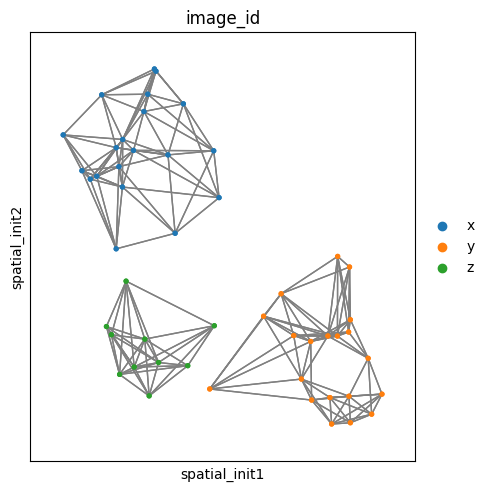

In [87]:
sq.gr.spatial_neighbors(adata_gt, spatial_key="spatial_init", library_key="image_id")
print(adata_gt)
sq.pl.spatial_scatter(
    adata_gt,
    spatial_key="spatial_init",
    shape=None,
    color="image_id",
    size=30,
    connectivity_key="spatial_connectivities",
)

AnnData object with n_obs × n_vars = 50 × 2
    obs: 'cell_type', 'image_id'
    uns: 'spatial_neighbors', 'image_id_colors'
    obsm: 'spatial_init'
    obsp: 'spatial_connectivities', 'spatial_distances'


/home/icb/francesca.drummer/tools/apps/mamba/envs/geome/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:483: FutureWarning: The default value of 'ignore' for the `na_action` parameter in pandas.Categorical.map is deprecated and will be changed to 'None' in a future version. Please set na_action to the desired value to avoid seeing this warning
  color_vector = color_source_vector.map(color_map)
/home/icb/francesca.drummer/tools/apps/mamba/envs/geome/lib/python3.11/site-packages/squidpy/pl/_spatial_utils.py:956: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = scatter(


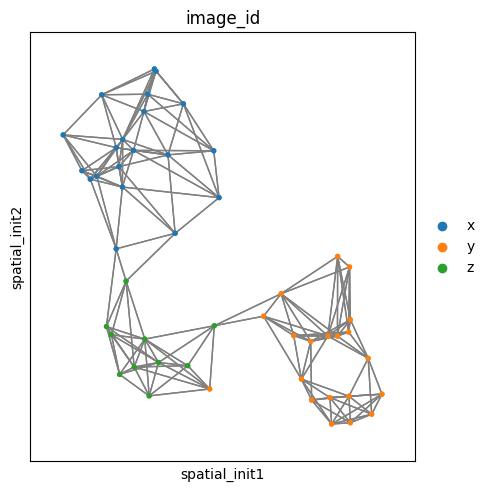

In [88]:
sq.gr.spatial_neighbors(adata_gt, spatial_key="spatial_init")
print(adata_gt)
sq.pl.spatial_scatter(
    adata_gt,
    spatial_key="spatial_init",
    shape=None,
    color="image_id",
    size=30,
    connectivity_key="spatial_connectivities",
)